In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install geopandas
! pip install rasterio
! pip install rasterstats
! pip install --quiet contextily matplotlib
#! pip install torch 
# pip install earthpy
#! pip install gdal 
#! pip install cupy-cuda111     #>=7.7.0,<8.0.0'
#! pip install torchfcn
#! pip install pyyaml h5py 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 24.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: fiona
    Found existing installation: Fiona 1.9.3
    Uninstalling Fiona-1.9.3:
      Successfully uninstalled Fiona-1.9.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.5 MB/s eta 0

In [3]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats
import contextily as ctx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

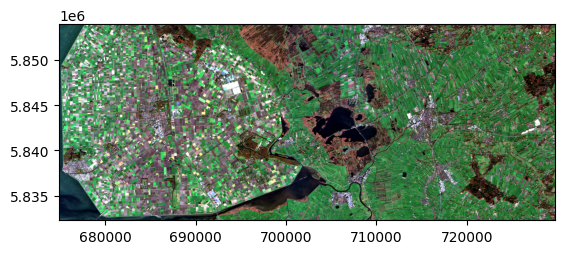

In [4]:
sat_img_path = "/content/drive/My Drive/INF-Msc_Thesis/Msc-Thesis-Crop-Type-Mapping/Data/sentinel2_2018_flevopolder_10m_7x4bands.tif"
def pct_clip(array,pct=[2,98]):
    array_min, array_max = np.nanpercentile(array,pct[0]), np.nanpercentile(array,pct[1])
    clip = (array - array_min) / (array_max - array_min)
    clip[clip>1]=1
    clip[clip<0]=0
    return clip

bands = 28

with rasterio.open(sat_img_path,crs='EPSG:3857') as src:
    with rasterio.open(
            'RGB_NIR.tif', 'w+',
            driver='GTiff',
            dtype= rasterio.float32,
            count=bands,
            crs= rasterio.crs.CRS.from_epsg(3857),
            width=src.width,
            height=src.height,
            transform=src.transform,
        ) as dst:
        for i in range(1,bands+1,4):
          V = pct_clip(src.read(i+3)) #NIR
          dst.write(V,i+3)
          V = pct_clip(src.read(i+2)) #R
          dst.write(V,i)
          V = pct_clip(src.read(i+1)) #G
          dst.write(V,i+1)
          V = pct_clip(src.read(i))   #B
          dst.write(V,i+2)
        dst.close()

fig,ax=plt.subplots()
with rasterio.open("RGB_NIR.tif") as src2:
    show(src2.read([25,26,27]),transform=src2.transform,ax=ax)

In [5]:
parcel_shapefile_path = "/content/drive/My Drive/INF-Msc_Thesis/Msc-Thesis-Crop-Type-Mapping/Data/cropparcels_2018_flevopolder.shp"
parcels = gpd.read_file(parcel_shapefile_path)
sat_img_path = "/content/drive/My Drive/INF-Msc_Thesis/Msc-Thesis-Crop-Type-Mapping/Data/sentinel2_2018_flevopolder_10m_7x4bands.tif"
#sat_img = rasterio.open(sat_img_path,crs='EPSG:3857')
sat_img = rasterio.open("RGB_NIR.tif") #,crs='EPSG:32631')

Text(0.5, 1.0, 'flevopolder parcels dataset')

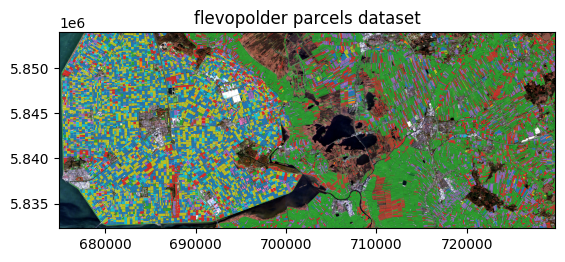

In [6]:
fig,ax = plt.subplots()#1,2,figsize=(24,12))
#ax = axs[0]
ax = show(sat_img.read([25,26,27]),transform=sat_img.transform,ax=ax)
ax.set_title("flevopolder satelite image")
#ctx.add_basemap(ax, crs='epsg:32631')
#ax = axs[1]
ax = parcels.to_crs(epsg=32631).plot(column="GWS_GEWAS", ax=ax, legend=False)
ax.set_title("flevopolder parcels dataset")
#ctx.add_basemap(ax, crs='epsg:32631')

In [32]:
#reclass parcels to 9 classes
classlist = []
classcodelist = []

#classify based on crop code, these can be added or changed if needed
for i in range(len(parcels)):
  GWS_code = parcels.loc[i,'GWS_GEWASC']
  if GWS_code == "265":
    Cropclass = "permanent meadows"
    classcode = 0
  elif GWS_code == "266":
    Cropclass = "temporary meadows"
    classcode = 1
  elif GWS_code == "235" or GWS_code =="236":
    Cropclass = "barley"
    classcode = 2
  elif GWS_code == "256" or GWS_code =="257":
    Cropclass = "beet"
    classcode = 3
  elif GWS_code == "814" or GWS_code =="316" or GWS_code =="317" or GWS_code =="259":
    Cropclass = "maize"
    classcode = 4
  elif GWS_code == "1001" or GWS_code =="1002" or GWS_code =="999" or GWS_code =="1004" or GWS_code =="998":
    Cropclass = "flowers"
    classcode = 5
  elif GWS_code == "2025" or GWS_code =="2017" or GWS_code =="2016" or GWS_code =="2015" or GWS_code =="2014":
    Cropclass = "potato"
    classcode = 6
  elif GWS_code == "1931" or GWS_code =="263" or GWS_code =="262":
    Cropclass = "union"
    classcode = 7
  elif GWS_code =="233" or GWS_code =="234":
    Cropclass = "wheat"
    classcode = 8
  elif GWS_code =="336" or GWS_code =="331" or GWS_code =="332":
    Cropclass = "grassland nature"
    classcode = 9
  elif GWS_code =="2787":
    Cropclass = "chicory"
    classcode = 10 
  elif GWS_code =="2785" or GWS_code =="2783" or GWS_code =="1036":
    Cropclass = "carrot"
    classcode = 11
  elif GWS_code =="1096" or GWS_code =="1098" or GWS_code =="1078" or GWS_code =="1077":
    Cropclass = "orchards"
    classcode = 12
  elif GWS_code =="258":
    Cropclass = "luzerne"
    classcode = 13
  elif GWS_code =="335":
    Cropclass = "nature and heather"
    classcode = 14
  elif GWS_code =="383":
    Cropclass = "grass seeds"
    classcode = 15
  elif GWS_code =="2797":
    Cropclass = "cauliflower"
    classcode = 16
  elif GWS_code =="2773" or GWS_code == "2774":
    Cropclass = "spinach"
    classcode = 17
  elif GWS_code =="2737" or GWS_code == "1922" or GWS_code =="1923":
    Cropclass = "rapeseed"
    classcode = 18
  elif GWS_code =="244":
    Cropclass = "peas"
    classcode = 19
  else:
    Cropclass = "other"
    classcode = 99
  classlist.append(Cropclass)
  classcodelist.append(classcode)

#drop Class column if code block runs for a second time
if "Class" in parcels:
  parcels = parcels.drop("Class",axis= "columns")
if "Classcode" in parcels:
  parcels = parcels.drop("Classcode",axis= "columns")

#insert Class column
parcels.insert(6,'Class',classlist,True)
parcels.insert(7,'Classcode',classcodelist,True)

#save selection of dataset
parcels_class = parcels[parcels["Class"]!= "other"].reset_index(drop=True)
parcels_class = parcels_class.loc[parcels_class['Classcode'].isin(range(20))]

#show the newly added column
parcels_class.head(10)

,OBJECTID,CAT_GEWASC,GWS_GEWASC,GEOMETRIE_,GEOMETRI_1,GWS_GEWAS,Class,Classcode,geometry
0,1526214.0,Bouwland,2015,583.773774,19567.658998,"Aardappelen, poot NAK",potato,6,"POLYGON ((173756.887 525021.120, 173756.815 52..."
1,1526369.0,Grasland,265,334.018326,2203.146610,"Grasland, blijvend",permanent meadows,0,"POLYGON ((194350.532 525167.317, 194346.564 52..."
2,1526370.0,Grasland,265,710.269508,4240.062968,"Grasland, blijvend",permanent meadows,0,"POLYGON ((194581.041 525183.137, 194574.426 52..."
3,1526371.0,Grasland,265,489.762016,9520.711108,"Grasland, blijvend",permanent meadows,0,"POLYGON ((194701.720 524314.531, 194574.058 52..."
4,1526388.0,Bouwland,259,1070.721971,27486.417515,"Maïs, snij-",maize,4,"POLYGON ((208647.070 526451.009, 208592.990 52..."
5,1526456.0,Grasland,265,251.156055,2383.092668,"Grasland, blijvend",permanent meadows,0,"POLYGON ((179399.401 531024.745, 179398.208 53..."
6,1526457.0,Bouwland,262,681.453720,27005.621675,"Uien, zaai-",union,7,"POLYGON ((180572.893 530484.068, 180571.448 53..."
7,1526495.0,Bouwland,233,977.315692,57508.883191,"Tarwe, winter-",wheat,8,"POLYGON ((184164.687 525545.153, 184064.071 52..."
8,1526504.0,Bouwland,233,1031.901695,52394.866931,"Tarwe, winter-",wheat,8,"POLYGON ((182561.417 515412.945, 182561.417 51..."
9,1526505.0,Bouwland,2787,991.192692,58837.181334,"Witlofwortel, productie",chicory,10,"POLYGON ((183150.648 517375.969, 183150.648 51..."


Text(0.5, 1.0, '20 classes dataset')

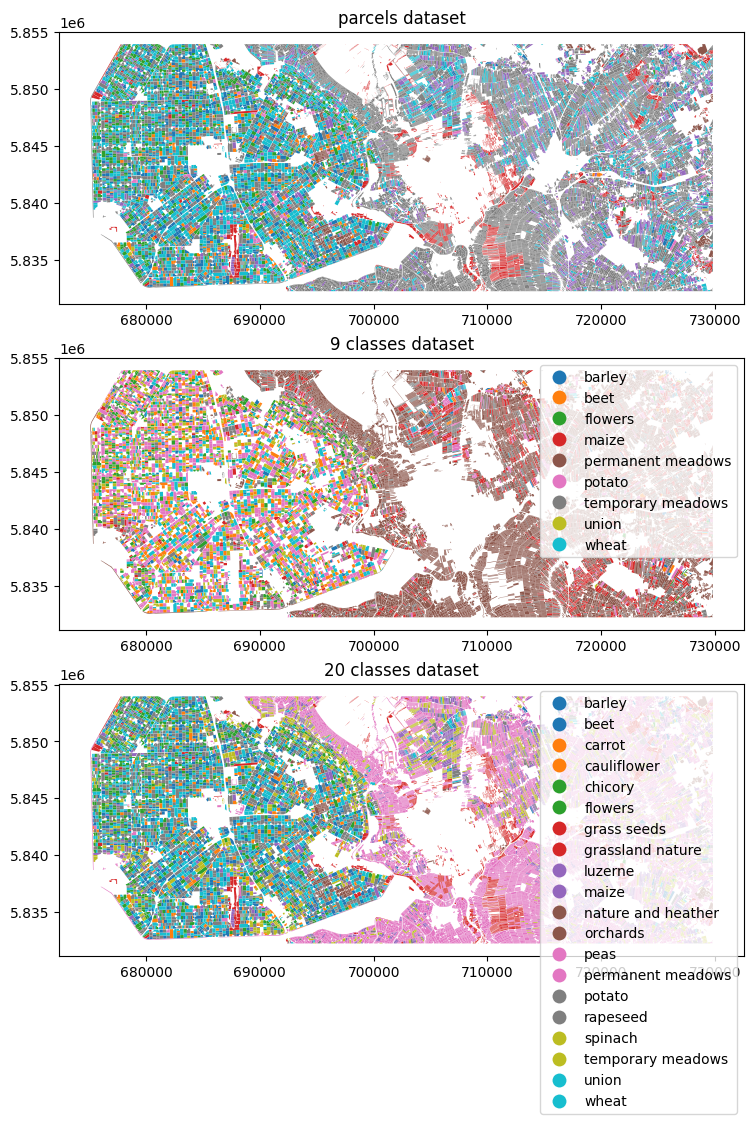

In [33]:
fig,axs = plt.subplots(3,1,figsize=(24,12))
ax = axs[0]
ax = parcels.to_crs(epsg=32631).plot(column="Class", ax=ax, legend=False)
ax.set_title("parcels dataset")
ax = axs[1]
ax = parcels_class.loc[parcels_class['Classcode'].isin(range(9))].to_crs(epsg=32631).plot(column="Class", ax=ax, legend=True)
ax.set_title("9 classes dataset")
ax = axs[2]
ax = parcels_class.loc[parcels_class['Classcode'].isin(range(20))].to_crs(epsg=32631).plot(column="Class", ax=ax, legend=True)
ax.set_title("20 classes dataset")
#ctx.add_basemap(ax, crs='epsg:32631')

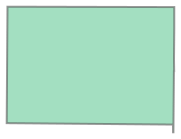

In [34]:
parcels_class.loc[0,'geometry']

In [35]:
# calculate zonal statistics of each polygon
# taking the mean value of all pixels underneath a polygon
parcels_class = parcels_class.to_crs(epsg=32631)


meanlist= np.zeros((len(parcels_class),28))

for i in tqdm(range(28)): # read all pictures 7 time spans for 4 bands shoould be 28 but chan be changed to factors of 4 to read less time spans
  array = sat_img.read(i+1)
  affine = sat_img.transform
  print(i)
  for j in range(len(parcels_class)): #calculate the mean pixel value on each band
    parcel = parcels_class.loc[j,'geometry']
    mean = zonal_stats(parcel, array, affine=affine, stats=['mean'])
    meanlist[j,i]=(mean[0]['mean'])
    

# outputs a table of all mean values having 28 colums, 1 for each band 
meanlist_df = pd.DataFrame(meanlist)
complete_df = pd.concat([parcels_class,meanlist_df],axis=1)

  0%|          | 0/28 [00:00<?, ?it/s]

0


/usr/local/lib/python3.9/dist-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [1]:
len(complete_df)

NameError: ignored

In [36]:
# save the complete dataframe to csv 
save_path = "/content/drive/My Drive/INF-Msc_Thesis/Msc-Thesis-Crop-Type-Mapping/Data/complete_df.csv"
complete_df.to_csv(save_path)